Задача: реализовать несколько агентов с разными сценариями игры в «камень-ножницы-бумага» и сравнить их в игре.

Возможные сценарии агентов:
1. Агент, который всегда выбрасывает один и тот же вариант (только "камень", только "ножницы" или только "бумага").
2. Выбрасывает всегда разные варианты в любом порядке (рандомные).
3. Выбрасывает рандомный вариант, но без повторов (не повторяет прыдущий ход).
4. Выбрасывает разные варианты последовательно и циклично (например, всегда в последовательности "камень", затем "ножницы", затем "бумага").
5. Повторяет предыдущий ход противника.
6. Выбрасывает вариант, который бьёт предыдущий ход противника, ожидая, что тот его повторит (т.к. есть исследования, показывающие, что человек, который победил в предыдущем раунде, в следующем выбирает тот же предмет, в то время как проигравший практически всегда его меняет).
7. Наоборот, агент выбрасывает вариант, исходя из предположения, что противник будет "бить" его предыдущий вариант. Т.к., если агент победил, то соперник ожидает в следующем раунде того же предмета, которым только что его победили.
8. Выбрасывает один из, так называемых, "Восьми великих гамбитов" (стратегий профессиональных игроков) - "Сэндвич" – бумага, ножницы, бумага.
9. Другой вариант из "Восьми великих гамбитов" - "Крещендо»": бумага, ножницы, камень.
10. Смешение стратегии "крещендо" и рандомного выбора.
11. Победная стратегия, найденная в интернете, №1: если вы проиграли, в следующем раунде выбирайте третий предмет (ваши ножницы побили камнем, значит, третий предмет – бумага).
13. Победная стратегия, найденная в интернете, №2: если вы выиграли, в следующем раунде выбирайте то, что показал противник в первом.

In [1]:
pip install kaggle-environments

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.6 MB/s eta 0:00:00
  Created wheel for Chessnut: filename=Chessnut-0.3.1-py3-none-any.whl size=10034 sha256=346deb5c5be2b7cf02c30e0ffb5e34256a6050bd1163972f555bcdd93f2f0390
  Stored in directory: /root/.cache/pip/wheels/30/25/8e/c31548e85b37e2434090132a05b1756513c4d0f494defb8244
Successfully built Chessnut


In [130]:
from kaggle_environments import make

# Определяем победителя
def determine_winner(agent_action, opponent_action):
    # Сравнение ходов по правилам игры
    if agent_action == opponent_action:
        return "Ничья"
    elif (agent_action - opponent_action) % 3 == 1:
        return "Агент"
    else:
        return "Оппонент"

# Функция для игры и подсчёта результатов
def play_game(agent, opponent, num_rounds=10, render=False):
    env = make("rps", configuration={"episodeSteps": num_rounds}, debug=True)
    steps = env.run([agent, opponent])

    agent_wins = 0

    for step in steps:
        agent_action = step[0]['action']
        opponent_action = step[1]['action']

        if determine_winner(agent_action, opponent_action) == "Агент":
            agent_wins += 1

    return agent_wins

In [131]:
# Агент №1 - всегда выбрасывает "камень" ("камень" = 0)
def agent1_rock(observation, configuration):
    return 0

In [132]:
# Агент №2 - выбрасывает рандомный вариант
def agent2_random(observation, configuration):
    return random.randrange(0, configuration.signs)

In [133]:
# Агент №3 - выбрасывает рандомный вариант, но без повторов (рандомный - первый ход)
def agent3_no_repeat(observation, configuration):
    if observation.step == 0:
        return random.randrange(0, configuration.signs)
    return (observation.lastOpponentAction + 1) % configuration.signs

In [134]:
# Агент №4 - выбирает варианты последовательно и циклично (камень => ножницы => бумага)
def agent4_cyclic(observation, configuration):
    moves = [0, 2, 1]
    return moves[observation.step % len(moves)]

In [135]:
# Агент №5 - повторяет предыдущий ход противника (первый ход рандомный, затем повторяет ход противника)
def agent5_copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    return random.randrange(0, configuration.signs)

In [148]:
# Агент №6 - выбирает то, что бьёт предыдущий ход противника (на первом ходу возвращаем "камень")
def agent6_win_previous(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % configuration.signs
    return 0

In [149]:
# Агент №7 - противник будет бить мой предыдущий ход (использую lastOpponentAction, т.к. agentAction выдаёт ошибку)
def agent7_win_my_previous(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % configuration.signs
    return 0

In [138]:
# Агент №8 - "Сэндвич": бумага, ножницы, бумага
def agent8_sandwich(observation, configuration):
    moves = [1, 2, 1]
    return moves[observation.step % len(moves)]

In [139]:
# Агент №9 - "Крещендо": бумага, ножницы, камень
def agent9_crescendo(observation, configuration):
    moves = [1, 2, 0]
    return moves[observation.step % len(moves)]

In [165]:
# Тестирование стратегий
# Оппонент (рандомный выбор)
def opponent_random(observation, configuration):
    import random
    return random.randrange(0, configuration.signs)

# Все 9 стратегий
strategies = [
    (agent1_rock, "Всегда камень"),
    (agent2_random, "Случайный выбор"),
    (agent3_no_repeat, "Рандомный без повторов"),
    (agent4_cyclic, "Цикличный выбор"),
    (agent5_copy_opponent, "Копия противника"),
    (agent6_win_previous, "Бить предыдущий ход противника"),
    (agent7_win_my_previous, "Бить мой предыдущий ход"),
    (agent8_sandwich, "Сэндвич"),
    (agent9_crescendo, "Крещендо"),
]

# Результаты тестов
test_results = []

for agent, name in strategies:
    print(f"\n{name}")
    agent_wins = play_game(agent, opponent_random, render=True)
    print(f"Побед агент: {agent_wins}")
    test_results.append((name, agent_wins))


Всегда камень
Побед агент: 4

Случайный выбор
Побед агент: 5

Рандомный без повторов
Побед агент: 3

Цикличный выбор
Побед агент: 2

Копия противника
Побед агент: 2

Бить предыдущий ход противника
Побед агент: 2

Бить мой предыдущий ход
Побед агент: 2

Сэндвич
Побед агент: 4

Крещендо
Побед агент: 2


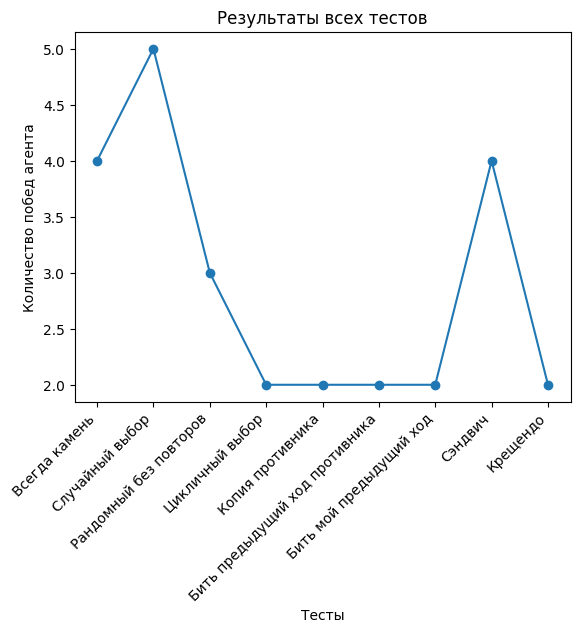

In [167]:
#Вывод результатов всех тестов
import matplotlib.pyplot as plt

# Построение графика
test_names = [name for name, _ in test_results]
test_scores = [wins for _, wins in test_results]

plt.plot(test_names, test_scores, marker='o', linestyle='-')
plt.title("Результаты всех тестов")
plt.ylabel("Количество побед агента")
plt.xlabel("Тесты")
plt.xticks(rotation=45, ha="right")
plt.show()

In [168]:
# Турнир между всеми стратегиями

# Счёт для каждой стратегии
agents = strategies
agent_scores = {name: 0 for _, name in agents}

# Турнир - каждая стратегия играет со всеми другими (но не сама с собой)
for i, (agent1, name1) in enumerate(agents):
    for j, (agent2, name2) in enumerate(agents):
        if i != j:
            agent1_wins = play_game(agent1, agent2, render=False)
            agent_scores[name1] += agent1_wins

# Итоги турнира
print("\nИтоги турнира (по всем матчам):")
for name, score in agent_scores.items():
    print(f"{name}: {score} очков")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Итоги турнира (по всем матчам):
Всегда камень: 13 очков
Случайный выбор: 28 очков
Рандомный без повторов: 23 очков
Цикличный выбор: 33 очков
Копия противника: 25 очков
Бить предыдущий ход противника: 13 очков
Бить мой предыдущий ход: 21 очков
Сэндвич: 30 очков
Крещендо: 19 очков


In [169]:
# Результат турнира, выбор победителя - стратегия с максимальным количеством очков
winner = max(agent_scores.items(), key=lambda x: x[1])
print(f"\nЛучше всех себя показывает стратегия: \n{winner[0]} - набрано {winner[1]} очков")


Лучше всех себя показывает стратегия: 
Цикличный выбор - набрано 33 очков
